
--- Processing ILI_Cases.csv (Flu data) ---
            ILI_Cases
Date                 
2010-10-03         16
2010-10-10         34
2010-10-17         28
2010-10-24         30
2010-10-31         24

--- Processing Avg_Temp.csv (Temperature data) ---
            Avg_Temp
DATE                
2010-01-01      48.5
2010-01-02      45.0
2010-01-03      43.5
2010-01-04      46.5
2010-01-05      47.0

--- Aligning and Merging Flu and Temperature Data ---
Resampled daily temp to weekly average. Preview:
             Avg_Temp
DATE                 
2010-01-03  45.666667
2010-01-10  46.285714
2010-01-17  47.714286
2010-01-24  48.285714
2010-01-31  46.142857

Successfully merged flu and temp data. Final data preview:
            ILI_Cases   Avg_Temp
2010-10-03         16  60.071429
2010-10-10         34  57.071429
2010-10-17         28  51.785714
2010-10-24         30  52.571429
2010-10-31         24  49.785714

Final dataset contains 469 weeks of data.

Created 'FINAL_MERGED_DATA.csv'.

--- Gene

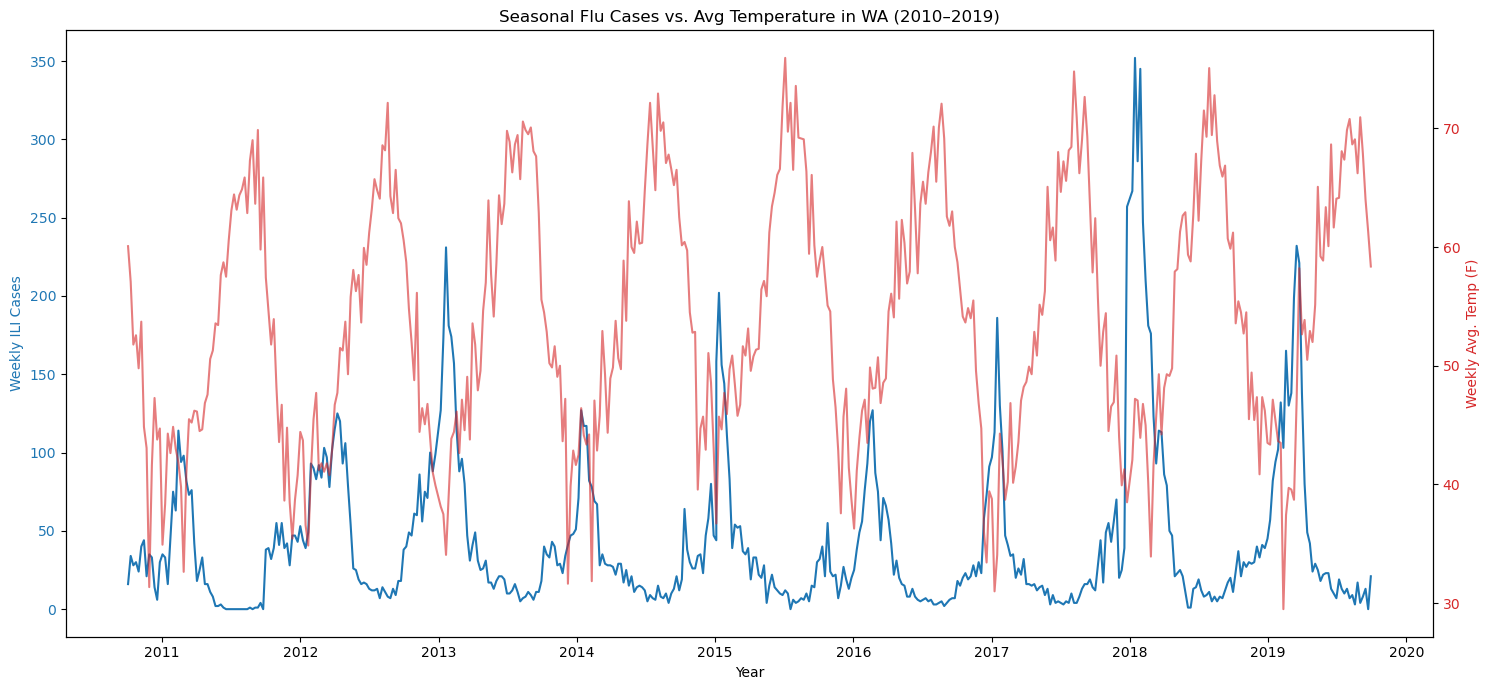

Saved: timeseries_plot.png

--- Generating scatter_plot.png ---


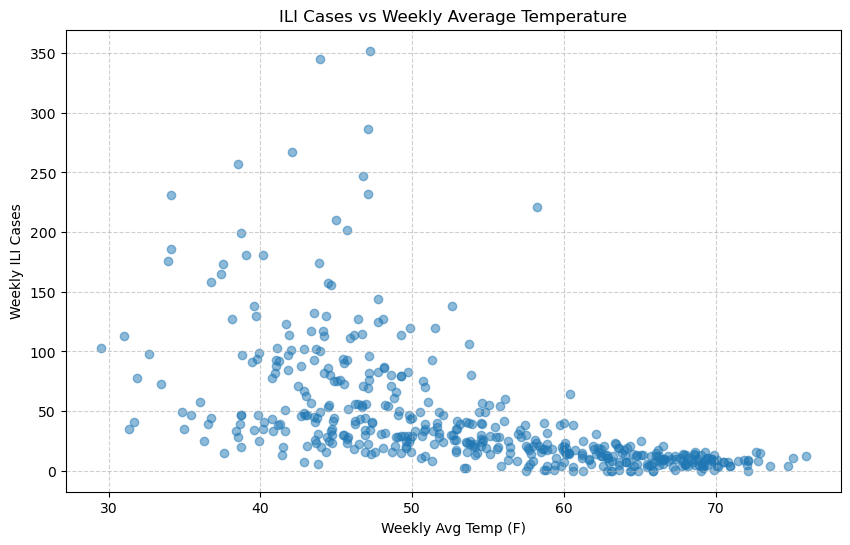

Saved: scatter_plot.png

--- Feature Engineering ---
            ILI_Cases   Avg_Temp  Temp_anom  cos_season
2010-10-03         16  60.071429  -6.155193    1.000000
2010-10-10         34  57.071429  -3.155193    0.992709
2010-10-17         28  51.785714   2.130521    0.970942
2010-10-24         30  52.571429   1.344807    0.935016
2010-10-31         24  49.785714   4.130521    0.885456

--- Train / Test Split ---
Train weeks: 2010-10-03 -> 2017-01-08
Test  weeks: 2017-01-15 -> 2019-09-29

--- Fitting Model 1: Temperature-driven ---
                            OLS Regression Results                            
Dep. Variable:              ILI_Cases   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     209.5
Date:                Tue, 02 Dec 2025   Prob (F-statistic):           5.21e-37
Time:                        19:33:24   Log-Likelihood:            

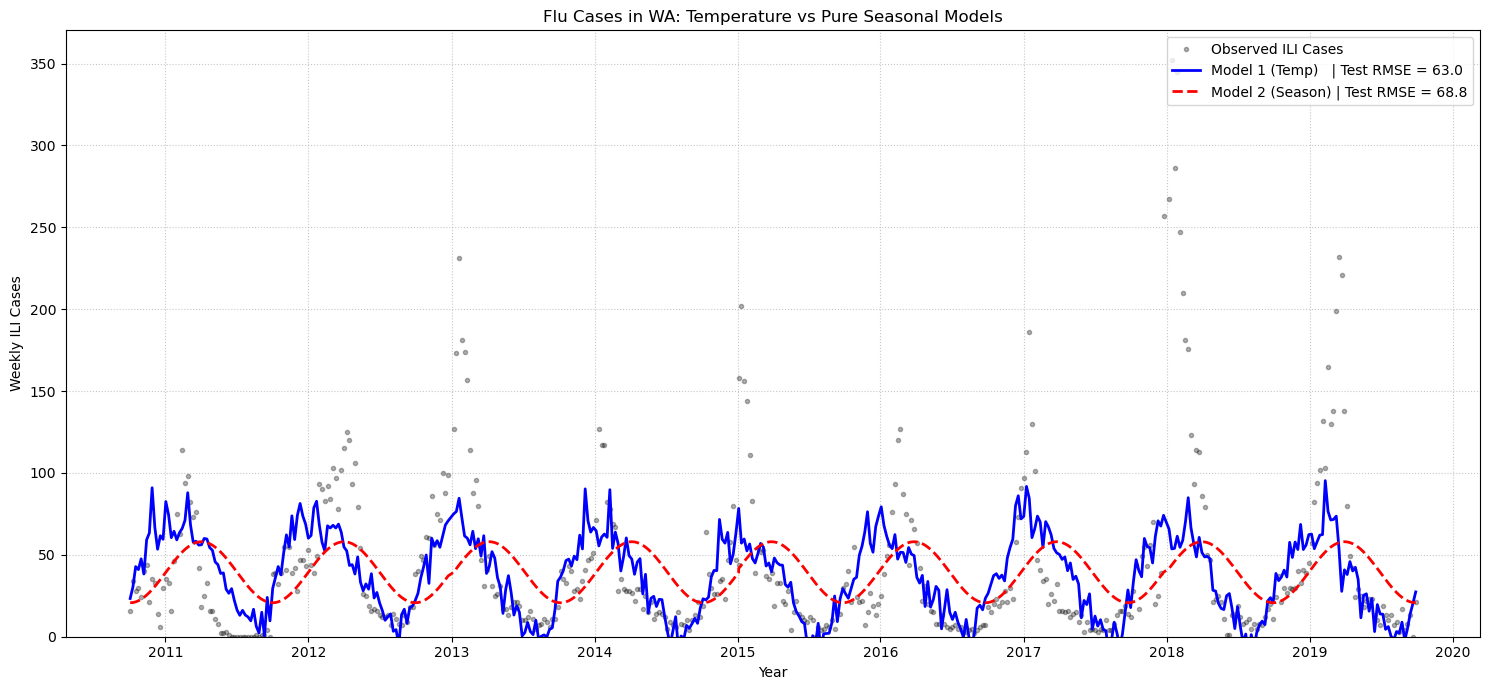

Saved: model_comparison_temp_vs_seasonal.png

--- FINAL COMPARISON TABLE (copy into report) ---

| Model | β(t) / Effect | AIC | Train RMSE | Test RMSE |
| :--- | :--- | :---: | :---: | :---: |
| **Model 1 (Temperature)** | $\beta(t) = \beta_0 + \alpha_T (T_{\mathrm{ref}} - T(t))$ | 3168.1 | 30.1 | 63.0 |
| **Model 2 (Seasonal)** | $\beta(t) = \beta_0(1 + \delta \cos(2\pi t/52))$ | 3290.4 | 36.3 | 68.8 |


In [27]:
# ============================================================
# AMATH 383 Final Project
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# ------------------------------------------------------------
# Part 1. Clean ILI_Cases.csv Data
# ------------------------------------------------------------

print("\n--- Processing ILI_Cases.csv (Flu data) ---")
try:
    df_flu_raw = pd.read_csv("ILI_Cases.csv", skiprows=1)
    df_flu = df_flu_raw[["YEAR", "WEEK", "ILITOTAL"]].copy()
    df_flu.rename(columns={"ILITOTAL": "ILI_Cases"}, inplace=True)
    df_flu["Date_str"] = (
        df_flu["YEAR"].astype(str)
        + "-"
        + df_flu["WEEK"].astype(str)
        + "-0"
    )
    df_flu["Date"] = pd.to_datetime(df_flu["Date_str"], format="%Y-%U-%w")
    df_flu.set_index("Date", inplace=True)
    df_flu_cleaned = df_flu[["ILI_Cases"]]

    print(df_flu_cleaned.head())

except Exception as e:
    print(f"*** Error processing ILI_Cases.csv: {e} ***")
    raise

# ------------------------------------------------------------
# Part 2. Clean Avg_Temp.csv Data
# ------------------------------------------------------------

print("\n--- Processing Avg_Temp.csv (Temperature data) ---")
try:
    df_temp_raw = pd.read_csv("Avg_Temp.csv")
    df_temp = df_temp_raw[["DATE", "TMAX", "TMIN"]].copy()
    tmax_nans = df_temp["TMAX"].isna().sum()
    tmin_nans = df_temp["TMIN"].isna().sum()
    if tmax_nans > 0 or tmin_nans > 0:
        print(
            f"Warning: {tmax_nans}/{tmin_nans} missing values in "
            "TMAX/TMIN. Filling by forward-fill..."
        )
        df_temp["TMAX"].ffill(inplace=True)
        df_temp["TMIN"].ffill(inplace=True)
    df_temp["Avg_Temp"] = (df_temp["TMAX"] + df_temp["TMIN"]) / 2.0
    df_temp["DATE"] = pd.to_datetime(df_temp["DATE"])
    df_temp.set_index("DATE", inplace=True)
    df_temp_daily = df_temp[["Avg_Temp"]]

    print(df_temp_daily.head())

except Exception as e:
    print(f"*** Error processing Avg_Temp.csv: {e} ***")
    raise

# ------------------------------------------------------------
# Part 3. Align and Merge Data
# ------------------------------------------------------------

print("\n--- Aligning and Merging Flu and Temperature Data ---")
try:
    df_temp_weekly = df_temp_daily.resample("W-SUN").mean()

    print(df_temp_weekly.head())
    df_merged = pd.merge(
        df_flu_cleaned,
        df_temp_weekly,
        left_index=True,
        right_index=True,
        how="inner",
    )

    print(df_merged.head())
    print(f"\nFinal dataset contains {len(df_merged)} weeks of data.")

except Exception as e:
    print(f"*** Error merging data: {e} ***")
    raise

try:
    df_merged.to_csv("FINAL_MERGED_DATA.csv")
    print("\nCreated 'FINAL_MERGED_DATA.csv'.")
except Exception as e:
    print(f"*** Error saving FINAL_MERGED_DATA.csv: {e} ***")

df = df_merged.copy()

# ------------------------------------------------------------
# Part 4. EDA Plot 1: Time series (ILI + Temperature)
# ------------------------------------------------------------

print("\n--- Generating timeseries_plot.png ---")

fig, ax1 = plt.subplots(figsize=(15, 7))

ax1.plot(df.index, df["ILI_Cases"], color="tab:blue", label="ILI Cases")
ax1.set_xlabel("Year")
ax1.set_ylabel("Weekly ILI Cases", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(df.index, df["Avg_Temp"], color="tab:red", alpha=0.6, label="Avg Temp")
ax2.set_ylabel("Weekly Avg. Temp (F)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.title("Seasonal Flu Cases vs. Avg Temperature in WA (2010–2019)")
plt.tight_layout()

fig.savefig("timeseries_plot.png")
plt.show()
plt.close(fig)
print("Saved: timeseries_plot.png")

# ------------------------------------------------------------
# Part 5. EDA Plot 2: Scatter (ILI vs Temperature)
# ------------------------------------------------------------

print("\n--- Generating scatter_plot.png ---")

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df["Avg_Temp"], df["ILI_Cases"], alpha=0.5)

ax.set_title("ILI Cases vs Weekly Average Temperature")
ax.set_xlabel("Weekly Avg Temp (F)")
ax.set_ylabel("Weekly ILI Cases")
ax.grid(True, linestyle="--", alpha=0.6)

fig.savefig("scatter_plot.png")
plt.show()
plt.close(fig)
print("Saved: scatter_plot.png")

# ------------------------------------------------------------
# Part 6. Temp anomaly + Seasonal cos
# ------------------------------------------------------------

print("\n--- Feature Engineering ---")
df = df.dropna().copy()
df["t"] = np.arange(len(df))
T_ref = df["Avg_Temp"].mean()
df["Temp_anom"] = T_ref - df["Avg_Temp"]  
df["cos_season"] = np.cos(2 * np.pi * df["t"] / 52.0)

print(df[["ILI_Cases", "Avg_Temp", "Temp_anom", "cos_season"]].head())

# ------------------------------------------------------------
# Part 7. Train / Test Split 
# ------------------------------------------------------------

print("\n--- Train / Test Split ---")

split_idx = int(0.7 * len(df)) 
train = df.iloc[:split_idx].copy()
test = df.iloc[split_idx:].copy()

y_train = train["ILI_Cases"]
y_test = test["ILI_Cases"]

print("Train weeks:", train.index.min().date(), "->", train.index.max().date())
print("Test  weeks:", test.index.min().date(), "->", test.index.max().date())

# ------------------------------------------------------------
# Part 8. Model 1:
# ILI_Cases(t) ≈ β0 + α_T * Temp_anom(t)
# ------------------------------------------------------------

print("\n--- Fitting Model 1: Temperature-driven ---")

X1_train = sm.add_constant(train["Temp_anom"])
X1_test = sm.add_constant(test["Temp_anom"], has_constant="add")

model1 = sm.OLS(y_train, X1_train).fit()
print(model1.summary())

pred1_train = model1.predict(X1_train)
pred1_test = model1.predict(X1_test)

rmse1_train = mean_squared_error(y_train, pred1_train, squared=False)
rmse1_test = mean_squared_error(y_test, pred1_test, squared=False)

print(f"\nModel 1 (Temp) AIC        : {model1.aic:.2f}")
print(f"Model 1 (Temp) Train RMSE : {rmse1_train:.2f}")
print(f"Model 1 (Temp) Test  RMSE : {rmse1_test:.2f}")

# ------------------------------------------------------------
# Part 9. Model 2: 
# ILI_Cases(t) ≈ β0 + β1 * cos(2π t / 52)
# ------------------------------------------------------------

print("\n--- Fitting Model 2: Pure Seasonal (cosine) ---")

X2_train = sm.add_constant(train["cos_season"])
X2_test = sm.add_constant(test["cos_season"], has_constant="add")

model2 = sm.OLS(y_train, X2_train).fit()
print(model2.summary())

pred2_train = model2.predict(X2_train)
pred2_test = model2.predict(X2_test)

rmse2_train = mean_squared_error(y_train, pred2_train, squared=False)
rmse2_test = mean_squared_error(y_test, pred2_test, squared=False)

print(f"\nModel 2 (Seasonal) AIC        : {model2.aic:.2f}")
print(f"Model 2 (Seasonal) Train RMSE : {rmse2_train:.2f}")
print(f"Model 2 (Seasonal) Test  RMSE : {rmse2_test:.2f}")

# ------------------------------------------------------------
# Part 10. Final Comparison Plot
# ------------------------------------------------------------

print("\n--- Generating model_comparison_temp_vs_seasonal.png ---")

fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(df.index, df["ILI_Cases"], "o", color="black",
        alpha=0.3, markersize=3, label="Observed ILI Cases")

X1_full = sm.add_constant(df["Temp_anom"])
X2_full = sm.add_constant(df["cos_season"])

pred1_full = model1.predict(X1_full)
pred2_full = model2.predict(X2_full)

ax.plot(df.index, pred1_full, color="blue", linewidth=2,
        label=f"Model 1 (Temp)   | Test RMSE = {rmse1_test:.1f}")
ax.plot(df.index, pred2_full, color="red", linestyle="--", linewidth=2,
        label=f"Model 2 (Season) | Test RMSE = {rmse2_test:.1f}")

ax.set_xlabel("Year")
ax.set_ylabel("Weekly ILI Cases")
ax.set_title("Flu Cases in WA: Temperature vs Pure Seasonal Models")

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax.set_ylim(bottom=0)
ax.grid(True, linestyle=":", alpha=0.7)
ax.legend(loc="upper right")

plt.tight_layout()
fig.savefig("model_comparison_temp_vs_seasonal.png")
plt.show()
plt.close(fig)

print("Saved: model_comparison_temp_vs_seasonal.png")

# ------------------------------------------------------------
# Part 11. Comparison table 
# ------------------------------------------------------------

print("\n--- FINAL COMPARISON TABLE (copy into report) ---\n")
print("| Model | β(t) / Effect | AIC | Train RMSE | Test RMSE |")
print("| :--- | :--- | :---: | :---: | :---: |")
print(
    f"| **Model 1 (Temperature)** | "
    r"$\beta(t) = \beta_0 + \alpha_T (T_{\mathrm{ref}} - T(t))$"
    f" | {model1.aic:.1f} | {rmse1_train:.1f} | {rmse1_test:.1f} |"
)
print(
    f"| **Model 2 (Seasonal)** | "
    r"$\beta(t) = \beta_0(1 + \delta \cos(2\pi t/52))$"
    f" | {model2.aic:.1f} | {rmse2_train:.1f} | {rmse2_test:.1f} |"
)
